In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

In [2]:
# Load the dataset
file_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn (1).csv'
df = pd.read_csv(file_path)

# Display the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Streami

In [3]:
# Convert 'Churn' column to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


# Prepare features and target variable
X = df[['tenure', 'MonthlyCharges', 'PaymentMethod', 'Contract', 'OnlineSecurity',
         'InternetService', 'TechSupport', 'MultipleLines']]
y = df['Churn']




Missing values in each column:
Series([], dtype: int64)


In [4]:
# Create a numerical and categorical imputer
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns


# Apply the imputer to the respective columns
X[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Check for missing values after imputation
missing_values_after_imputation = X.isnull().sum()
print("Missing values after imputation:")
print(missing_values_after_imputation[missing_values_after_imputation > 0])

Missing values after imputation:
Series([], dtype: int64)


<ipython-input-4-c4d8c46402eb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])
<ipython-input-4-c4d8c46402eb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])


In [6]:
# Existing numeric and categorical features
numeric_features = ['tenure', 'MonthlyCharges']
categorical_features = ['PaymentMethod', 'Contract', 'OnlineSecurity', 'InternetService',
                       'TechSupport', 'MultipleLines']

# Log transformation for skewness
skewness = X[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_features = skewness[skewness > 0.5].index

for feature in skewed_features:
    X[feature] = np.log1p(X[feature])  # Apply log transformation


In [7]:
# Apply Box-Cox transformation for right skewness
from scipy.stats import boxcox
for feature in skewed_features:
    X[feature], _ = boxcox(X[feature] + 1)  # Apply Box-Cox transformation

left_skewed_features = skewness[skewness < -0.5].index
for feature in left_skewed_features:
    median_val = X[feature].median()
    X[feature] = median_val - (X[feature] - median_val)  # Reflect
    X[feature] = np.log1p(X[feature] + 1)  # Apply log transformation
    X[feature] = median_val - (X[feature] - median_val)  # Reflect back


In [9]:
# Existing code from ipython-input-8-a3f403c8c893
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution before handling imbalance
print("Class distribution before handling imbalance:\n", y_train.value_counts())

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
categorical_features = ['PaymentMethod', 'Contract', 'OnlineSecurity', 'InternetService', 'TechSupport', 'MultipleLines']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # Passthrough for numeric features
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)  # OneHotEncoder for categorical features
    ])

# Fit and transform the data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# Check class distribution after handling imbalance
print("Class distribution after handling imbalance:\n", y_train_resampled.value_counts())

Class distribution before handling imbalance:
 Churn
0    4138
1    1496
Name: count, dtype: int64
Class distribution after handling imbalance:
 Churn
0    4138
1    4138
Name: count, dtype: int64


In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing
numeric_features = ['tenure', 'MonthlyCharges']
categorical_features = ['PaymentMethod', 'Contract', 'OnlineSecurity', 'TechSupport', 'MultipleLines', 'InternetService']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Fit the model
try:
    model.fit(X_train, y_train)
    print("Model trained successfully.")
except Exception as e:
    print(f"An error occurred during model training: {e}")


Model trained successfully.


Correlation Matrix (All Features):
                                           tenure  MonthlyCharges  \
tenure                                   1.000000        0.247900   
MonthlyCharges                           0.247900        1.000000   
PaymentMethod_Bank transfer (automatic)  0.243510        0.042812   
PaymentMethod_Credit card (automatic)    0.233006        0.030550   
PaymentMethod_Electronic check          -0.208363        0.271625   
PaymentMethod_Mailed check              -0.233852       -0.377437   
Contract_Month-to-month                 -0.645561        0.060165   
Contract_One year                        0.202570        0.004904   
Contract_Two year                        0.558533       -0.074681   
OnlineSecurity_No                       -0.263746        0.360898   
OnlineSecurity_No internet service      -0.039062       -0.763557   
OnlineSecurity_Yes                       0.327203        0.296594   
InternetService_DSL                      0.013274       -0.160189   

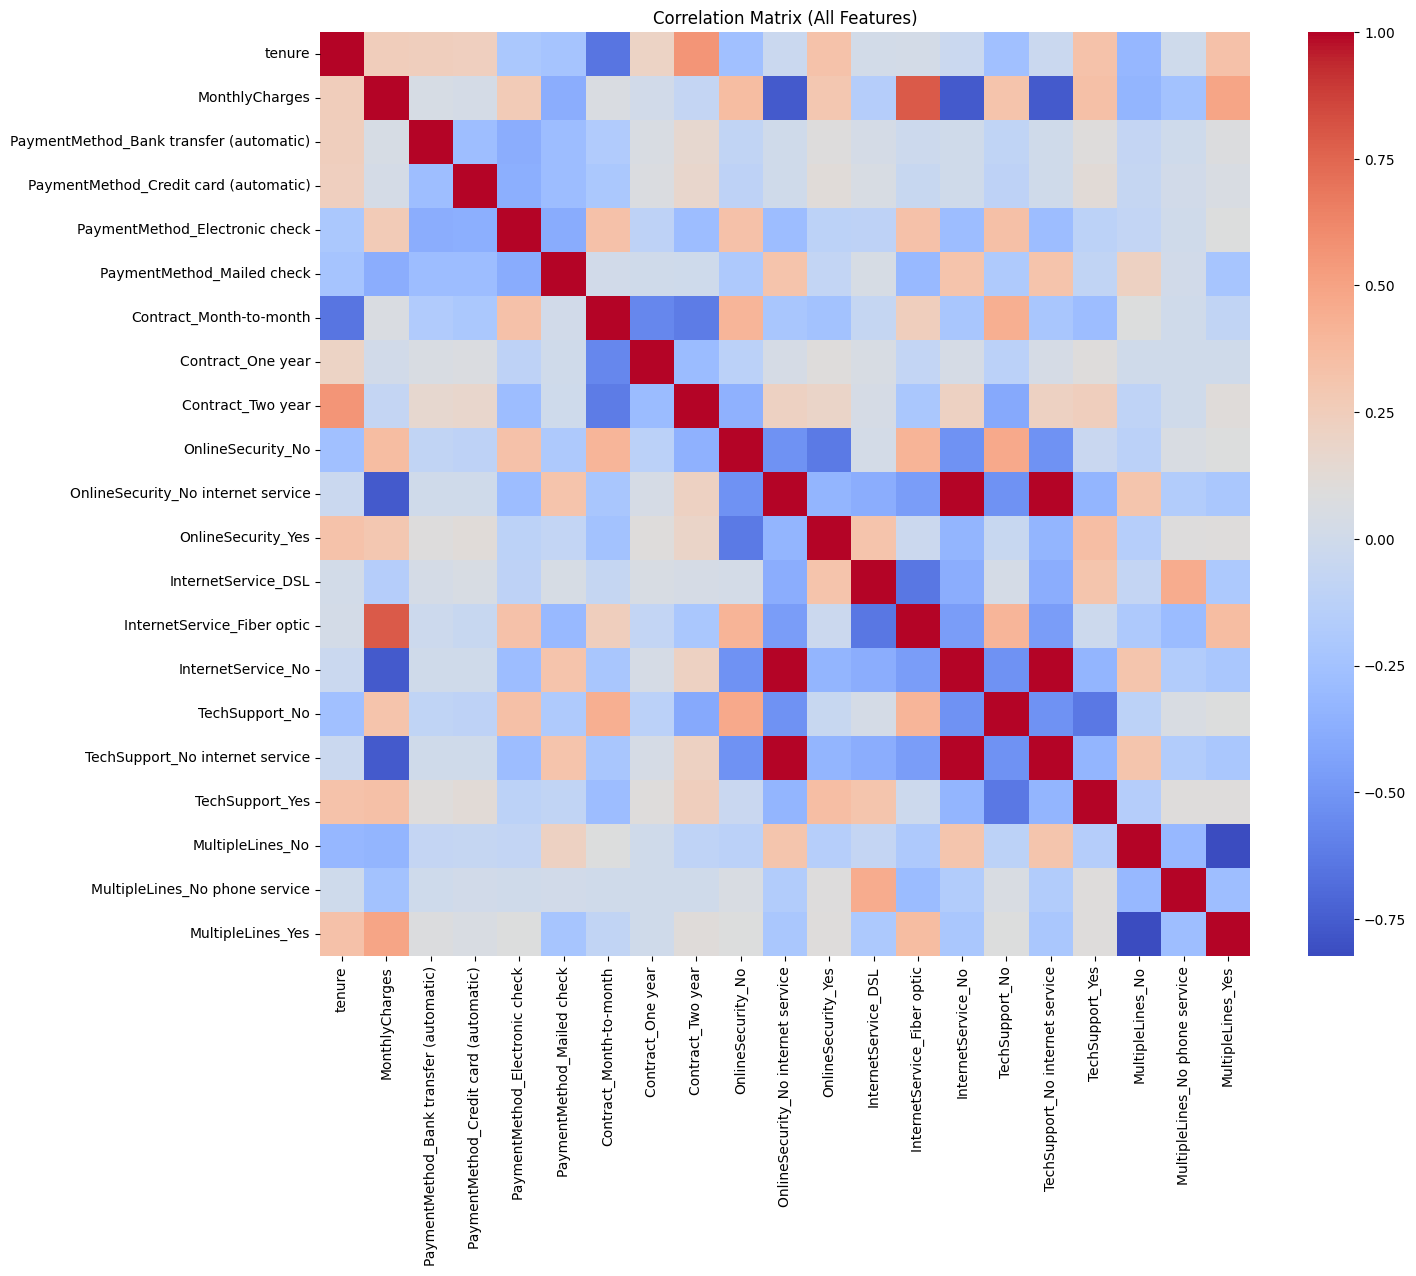

In [11]:
# Calculate the correlation matrix for all features (numeric and categorical)
correlation_matrix_all = pd.get_dummies(X).corr()

# Display the correlation matrix for all features
print("Correlation Matrix (All Features):")
print(correlation_matrix_all)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 12))  # Adjust the figure size for better visibility
sns.heatmap(correlation_matrix_all, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (All Features)')
plt.show()

In [12]:
from sklearn.svm import SVC

# Create the model pipeline with SVM
svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Fit the SVM model
try:
    svm_model.fit(X_train, y_train)
    print("SVM model trained successfully.")
except Exception as e:
    print(f"An error occurred during SVM model training: {e}")

# Make predictions with the SVM model
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
print("SVM Model Evaluation:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

SVM model trained successfully.
SVM Model Evaluation:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1036
           1       0.69      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Accuracy: 0.8119233498935415
Confusion Matrix:
 [[945  91]
 [174 199]]


In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}


grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Predict using the test data with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best Cross-Validation Accuracy: 0.7983667480429503


In [14]:

from sklearn.linear_model import LogisticRegression

# Create the model pipeline with Logistic Regression
logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Increase max_iter if needed
])

# Fit the Logistic Regression model
try:
    logistic_model.fit(X_train, y_train)
    print("Logistic Regression model trained successfully.")
except Exception as e:
    print(f"An error occurred during Logistic Regression model training: {e}")

# Make predictions with the Logistic Regression model
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print(classification_report(y_test, y_pred_logistic))
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))

Logistic Regression model trained successfully.
Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1036
           1       0.67      0.57      0.62       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.75      1409
weighted avg       0.80      0.81      0.81      1409

Accuracy: 0.8119233498935415
Confusion Matrix:
 [[932 104]
 [161 212]]


In [16]:
# Import necessary libraries for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Assuming X_train_resampled, y_train_resampled, X_test_encoded, y_test are defined from previous code

# Define the deep learning model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_encoded, y_test)
print("Deep Learning Model Evaluation:")
print("Loss:", loss)
print("Accuracy:", accuracy)

# Make predictions
y_pred_deep = (model.predict(X_test_encoded) > 0.5).astype(int)

# Print classification report and confusion matrix (similar to other models)
print(classification_report(y_test, y_pred_deep))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_deep))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6155 - loss: 2.1326 - val_accuracy: 0.6691 - val_loss: 0.5301
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6998 - loss: 0.6265 - val_accuracy: 0.6033 - val_loss: 0.6305
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7256 - loss: 0.5667 - val_accuracy: 0.6002 - val_loss: 0.7021
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7277 - loss: 0.5390 - val_accuracy: 0.6081 - val_loss: 0.6803
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7279 - loss: 0.5341 - val_accuracy: 0.6075 - val_loss: 0.7814
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7445 - loss: 0.5118 - val_accuracy: 0.6944 - val_loss: 0.6739
Epoch 7/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7399 - loss: 0.5139 - val_accuracy: 0.7132 - val_loss: 0.6036
Epoch 8/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7458 - loss: 0.5050 - val_accuracy: 0.

In [15]:
import joblib
# Save the trained model
joblib.dump(model, 'customer_churn_model.pkl')

['customer_churn_model.pkl']

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok config add-authtoken 2mlBokJkBJ3PSki24C2eu7VNVOl_2udn662gXcUGz7v6DS6TC

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install flask-cors

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import joblib
import pandas as pd
import threading
from pyngrok import ngrok
import numpy as np

app = Flask(__name__)
CORS(app)

# Load your trained model here
model_pipeline = joblib.load('customer_churn_model.pkl')  # Model with preprocessor

# Updated feature list
numeric_features = ['tenure', 'MonthlyCharges']
categorical_features = [
    'PaymentMethod', 'Contract', 'OnlineSecurity', 'TechSupport',
    'MultipleLines', 'InternetService'
]

@app.route('/predict_churn', methods=['POST'])
def predict_churn():
    try:
        input_data = request.json

        # Extract and process features into a DataFrame, including additional features
        features = {
            'tenure': input_data.get('num__tenure'),
            'MonthlyCharges': input_data.get('num__MonthlyCharges'),
            'PaymentMethod': input_data.get('cat__PaymentMethod'),
            'Contract': 'Two year' if input_data.get('cat__Contract_TwoYear') == 1 else 'Other',
            'OnlineSecurity': 'Yes' if input_data.get('cat__OnlineSecurity_Yes') == 1 else 'No',
            'TechSupport': 'Yes' if input_data.get('cat__TechSupport_Yes') == 1 else 'No',
            'MultipleLines': 'Yes' if input_data.get('cat__MultipleLines_Yes') == 1 else 'No',
            'InternetService': 'Yes' if input_data.get('cat__InternetService_Yes') == 1 else 'No'  # New feature
        }

        # Convert features into a DataFrame
        feature_df = pd.DataFrame([features])

        # Log-transform skewed numeric features if needed
        skewed_features = ['tenure', 'MonthlyCharges']
        for feature in skewed_features:
            if feature in feature_df.columns and feature_df[feature].skew() > 0.5:
                feature_df[feature] = np.log1p(feature_df[feature])

        # Make prediction using the fitted pipeline
        prediction = model_pipeline.predict(feature_df)[0]

        # Map prediction to churn status
        churn_status = "churned" if prediction == 1 else "not churned"

        return jsonify({'churn_prediction': churn_status})

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return jsonify({'error': str(e)}), 500

# Function to start ngrok
def start_ngrok():
    public_url = ngrok.connect(5016)
    print(" * Ngrok tunnel URL:", public_url)

if __name__ == '__main__':
    # Start ngrok in a separate thread
    threading.Thread(target=start_ngrok).start()

    # Run the Flask application
    app.run(port=5016)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5016
INFO:werkzeug:Press CTRL+C to quit


 * Ngrok tunnel URL: NgrokTunnel: "https://7aa2-34-145-211-166.ngrok-free.app" -> "http://localhost:5016"


INFO:werkzeug:127.0.0.1 - - [02/Nov/2024 12:20:46] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Nov/2024 12:22:08] "OPTIONS /predict_churn HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Nov/2024 12:22:09] "POST /predict_churn HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Nov/2024 12:22:09] "OPTIONS /predict_churn HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [02/Nov/2024 12:22:10] "POST /predict_churn HTTP/1.1" 200 -
